# SVM

In [3]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn import metrics
import requests

In [4]:
SCORINGS = ["roc_auc", "accuracy", "precision", "recall", "f1"]
METRIC = "roc_auc"

def grid_table(grid, params):
    tabla = pd.DataFrame(grid.cv_results_)
    tabla.sort_values("rank_test_" + METRIC, inplace = True)
    tabla.reset_index(inplace = True)
    cols = ["param_" + x for x in params] + ["mean_test_" + x for x in SCORINGS]
    return tabla[cols]

def metrics_table(model, X, Y):
    predicted = model.predict(X)
    probabilities = model.decision_function(X)
    roc_auc = metrics.roc_auc_score(Y, probabilities)
    f1 = metrics.f1_score(Y, predicted)
    acc = metrics.accuracy_score(Y, predicted)
    rec = metrics.recall_score(Y, predicted)
    prec = metrics.precision_score(Y, predicted)
    return pd.DataFrame.from_dict({
        "AUC-ROC": [roc_auc], "Accuracy": [acc], "Precision": [prec], "Recall": [rec], "F1 Score": [f1]
    })

## SVM Lineal (Grado 1) y Polinómico (Grados 2 y 3)

In [8]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
# El barrio tiene 49 valores distintos. Para no tener que hacer one hoy con 48 columnas nuevas, uso hashing trick/
# En total quedan 47 features luego de esto
df_features = hashing_trick(df_features, 24, "barrio")
pipe = iterative_imputer()
pipe = standarizer(pipe)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

In [6]:
# La grid tarda muchísimo en terminar, si se desea se puede cargar de archivo y saltear el próximo bloque
# de código, descomentando la siguiente línea. También se pueden saltear los próximos 3 bloques de código si
# solo se desea ver el modelo final con los parámetros encontrados.
# grid = load('SVM/polinomico_grid.joblib') 

In [5]:
X_grid = pipe.fit_transform(X_train)

grid = GridSearchCV(SVC(kernel = 'poly', random_state = 123, max_iter=100000),
                    param_grid = {
                        "C": [0.01, 1, 1000],
                        "coef0": [1, 1000],
                        "degree": [1, 2, 3],
                        "gamma": [0.001, 0.01, 1]
                    },
                    verbose = 1, n_jobs = -1, cv = 3, scoring = SCORINGS, refit = METRIC)

grid.fit(X_grid, Y_train.values.ravel())

grid.best_score_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver termi

0.8804586778572769

In [6]:
dump(grid, 'SVM/polinomico_grid.joblib') 

['SVM/polinomico_grid.joblib']

In [11]:
grid_table(grid, ["C", "degree", "coef0", "gamma"])

,param_C,param_degree,param_coef0,param_gamma,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,1,3,1,0.01,0.880459,0.858544,0.790836,0.499836,0.612527
1,1,2,1,0.01,0.876455,0.856150,0.787229,0.489134,0.603370
2,1,3,1,0.001,0.875499,0.849774,0.772615,0.465491,0.580922
3,0.01,3,1,0.01,0.875315,0.844595,0.805392,0.402588,0.536818
4,0.01,2,1,1,0.872609,0.857347,0.779234,0.505515,0.613215
5,0.01,2,1000,0.01,0.871613,0.848174,0.756023,0.474391,0.582960
6,1,2,1,0.001,0.871585,0.847343,0.764178,0.459430,0.573807
7,0.01,2,1,0.01,0.870375,0.839538,0.804965,0.373103,0.509859
8,1,2,1000,0.001,0.868428,0.847014,0.737581,0.490718,0.589304
9,0.01,2,1000,0.001,0.867644,0.845426,0.744845,0.470023,0.576326


Podemos ver que para la gran mayoría de las combinaciones de parámetros, el modelo no convergió en las 100000 iteraciones (el error nos sugiere estandarizar los datos, pero ya se hizo).

El mejor modelo resultó ser el de un polinomio de grado 3, con C = 1, coef0 = 1 y gamma = 0.01. Los primeros de la lista son todos de grado 3, lo cual tiene sentido al estar menos sesgados. Como el grid search utiliza cross validation, confiamos en que no overfittearon.

Vamos a entrenar un modelo con esos parámetros y probarlo con el set de validación.

In [9]:
pipe.steps.append(['svc', SVC(kernel = 'poly', random_state = 123, max_iter=100000,
                             C = 1, degree = 3, coef0 = 1, gamma = 0.01)])

pipe.fit(X_train, Y_train.values.ravel())

metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.882422,0.857094,0.793818,0.491518,0.607119


Con los parámetros encontrados, el modelo dio un accuracy de alrededor de 85,7% y área bajo la curva ROC de 0.882.

## SVM Radial (RBF)

In [5]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
# El barrio tiene 49 valores distintos. Para no tener que hacer one hoy con 48 columnas nuevas, uso hashing trick
df_features = hashing_trick(df_features, 24, "barrio")
pipe2 = iterative_imputer()
pipe2 = standarizer(pipe2)

# Son los mismos sets, tienen el mismo random state
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

In [8]:
# La grid tarda muchísimo en terminar, si se desea se puede cargar de archivo y saltear el próximo bloque
# de código, descomentando la siguiente línea. También se pueden saltear los próximos 3 bloques de código si
# solo se desea ver el modelo final con los parámetros encontrados.
# grid2 = load('SVM/radial_grid.joblib') 

In [19]:
X_grid = pipe2.fit_transform(X_train)

grid2 = GridSearchCV(SVC(kernel = 'rbf', random_state = 123, max_iter=100000),
                    param_grid = {
                        "C": [0.01, 1, 1000],
                        "gamma": [0.001, 0.01, 1]
                    },
                    verbose = 1, n_jobs = -1, cv = 3, scoring = SCORINGS, refit = METRIC)

grid2.fit(X_grid, Y_train.values.ravel())

grid2.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/delu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver termi

0.8791220991523808

In [25]:
dump(grid2, 'SVM/radial_grid.joblib') 

['SVM/radial_grid.joblib']

In [9]:
grid_table(grid2, ["C", "gamma"])

,param_C,param_gamma,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,1,0.01,0.879122,0.857762,0.788735,0.497379,0.610049
1,1,0.001,0.873783,0.848638,0.769968,0.461232,0.576850
2,1000,0.001,0.867683,0.857017,0.743791,0.551162,0.632968
3,0.01,0.01,0.866850,0.826860,0.838492,0.279950,0.419734
4,0.01,0.001,0.860568,0.777000,0.834213,0.003986,0.007932
5,1,1,0.780974,0.776548,0.646962,0.002403,0.004787
6,0.01,1,0.780150,0.776304,0.000000,0.000000,0.000000
7,1000,1,0.779413,0.776316,0.500000,0.007426,0.014631
8,1000,0.01,0.690681,0.720533,0.389446,0.430487,0.408606


Nuevamente, la mayoría de los modelos con cada combinación de los parámetros no logró converger antes de las iteraciones dadas. Casi todos los modelos dieron 77% de accuracy, lo cual es muy malo ya que probablemente hayan fiteado a decir siempre que "no" al estar desbalanceada la variable target. El que dio recall y precision en 0 overfitteo por completo (0 true positives, entonces 0 de recall y precision).

Los primeros si dieron valores más aceptables, siendo el de mejor el que usa C=1 y gamma=0.01. Vamos a utilizar esos valores para entrenar un modelo con todo el set de entrenamietno.

In [10]:
pipe2.steps.append(['svc', SVC(kernel = 'rbf', random_state = 123, max_iter=100000, C = 1, gamma = 0.01)])

pipe2.fit(X_train, Y_train.values.ravel())

metrics_table(pipe2, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.880191,0.856263,0.793409,0.486951,0.603504


En este caso el modelo radial dio un 0.880 de área bajo curva ROC y accuracy del 85,6%, muy levemente por debajo del polinómico. El  recall sigue siendo malo, tiene muchos falsos negativos.

## Con otro scaler

Como en SVM es bastante importante el escalado de los valores de las features, para mantener las distancias parejas, vamos a probar otro preprocesamiento con un MinMaxScaler con los parámetros del primer modelo a ver si da mejores resultados.

In [5]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)

df_features = hashing_trick(df_features, 24, "barrio")
pipe3 = iterative_imputer()
pipe3 = minmax(pipe3)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

In [6]:
pipe3.steps.append(['svc', SVC(kernel = 'poly', random_state = 123, max_iter=100000,
                             C = 1, degree = 3, coef0 = 1, gamma = 0.01)])

pipe3.fit(X_train, Y_train.values.ravel())

metrics_table(pipe3, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.869172,0.842974,0.75976,0.440191,0.557422


Dio un poco peor que con el StandardScaler, asi que nos vamos a quedar con ese.

## Predicción de nuevos datos

Como el modelo polinómico dio un poco mejor, vamos a utilizar este modelo para predecir sobre los nuevos datos

In [33]:
initialize_dataset()

df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
df_extra = hashing_trick(df_extra, 24, "barrio")

# El imputer y standarizer ya estan en el pipe

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,no
2533,no
7270,si
...,...
73456,no
14471,no
106482,no


In [34]:
df_extra_predict.to_csv("predicciones/SVM.csv")

## Predicciones en el holdout

In [11]:
initialize_dataset()

X_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
Y_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(X_holdout, Y_holdout)
viento_trigonometrico(X_holdout)
X_holdout = hashing_trick(X_holdout, 24, "barrio")

# El imputer y standarizer ya estan en el pipe

metrics_table(pipe, X_holdout, Y_holdout)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.885517,0.856842,0.796333,0.479684,0.59872


Dio resultados bastante buenos, mejores que en el set de validación en términos de AUC_ROC.

### Matriz de confusión

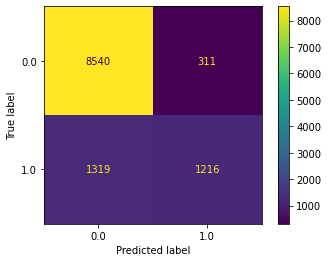

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_holdout, pipe.predict(X_holdout))
None

### Curva ROC

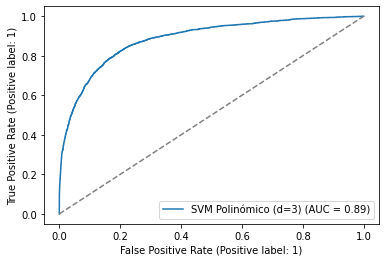

In [14]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(Y_holdout, pipe.decision_function(X_holdout), name = "SVM Polinómico (d=3)", ax = ax)
ax.plot([0, 1], [0, 1], "--", color="gray")
plt.show()